In [1]:
!pip install timm

     |████████████████████████████████| 346 kB 832 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


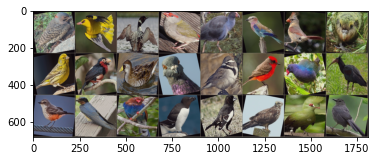

In [2]:
'''
We write this code with the help of PyTorch demo:
    https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
  

'''

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import timm
import random


RANDOM_SEED = 0

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

data_dir = '../input/100-bird-species'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)#, title=[class_names[x] for x in classes])

Showing 64 images when batch_size=64.

In [3]:


#%%

#model_ft = models.vgg11_bn(pretrained=True)
#num_ftrs = model_ft.classifier[0].in_features

model_ft = timm.create_model("vit_base_patch16_224", pretrained=True)
num_ftrs = model_ft.head.in_features

half_in_size = round(num_ftrs/2)
layer_width = 1024
Num_class=275

class SpinalNetV1(nn.Module):
    def __init__(self):
        super(SpinalNetV1, self).__init__()
        
        self.fc_spinal_layer1 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(layer_width*4, Num_class),)
        
    def forward(self, x):
        x1 = self.fc_spinal_layer1(x[:, 0:half_in_size])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,half_in_size:2*half_in_size], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:half_in_size], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,half_in_size:2*half_in_size], x3], dim=1))
        
        
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)

        
        x = self.fc_out(x)
        return x
    
class SpinalNetV2(nn.Module):
    def __init__(self):
        super(SpinalNetV2, self).__init__()
        
        self.fc_spinal_layer1 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(layer_width*4, Num_class),)        

    def forward(self, x):
        x1 = self.fc_spinal_layer1(x[:, 0:half_in_size])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,half_in_size:2*half_in_size], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:half_in_size], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,half_in_size:2*half_in_size], x3], dim=1))
        
        
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)

        
        x = self.fc_out(x)
        return x



net_fc = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, Num_class)
        )



#%%




def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    test_token=0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid', 'test']:
             
            
            '''
            Test when a better validation result is found
            '''
            if test_token ==0 and phase == 'test':
                continue
            test_token =0
            
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                test_token =1


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model




'''
Changing the fully connected layer to SpinalNet or ResNet or VGG
'''

#model_ft.fc = nn.Linear(num_ftrs, Num_class)
model_ft.head= SpinalNetV1() #SpinalNet_VGG#model_ft.classifier =SpinalNet_VGG()


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


Loading pre-trained model from PyTorch.

In [4]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 1.6395 Acc: 0.7820
valid Loss: 0.1671 Acc: 0.9724
test Loss: 0.1540 Acc: 0.9789

Epoch 1/19
----------
train Loss: 0.1592 Acc: 0.9667
valid Loss: 0.0774 Acc: 0.9876
test Loss: 0.0632 Acc: 0.9905

Epoch 2/19
----------
train Loss: 0.1008 Acc: 0.9777
valid Loss: 0.0583 Acc: 0.9876

Epoch 3/19
----------
train Loss: 0.0765 Acc: 0.9830
valid Loss: 0.0454 Acc: 0.9905
test Loss: 0.0349 Acc: 0.9942

Epoch 4/19
----------
train Loss: 0.0627 Acc: 0.9851
valid Loss: 0.0461 Acc: 0.9898

Epoch 5/19
----------
train Loss: 0.0510 Acc: 0.9881
valid Loss: 0.0434 Acc: 0.9913
test Loss: 0.0266 Acc: 0.9949

Epoch 6/19
----------
train Loss: 0.0442 Acc: 0.9899
valid Loss: 0.0362 Acc: 0.9898

Epoch 7/19
----------
train Loss: 0.0339 Acc: 0.9923
valid Loss: 0.0347 Acc: 0.9920
test Loss: 0.0196 Acc: 0.9971

Epoch 8/19
----------
train Loss: 0.0325 Acc: 0.9926
valid Loss: 0.0348 Acc: 0.9927
test Loss: 0.0194 Acc: 0.9978

Epoch 9/19
----------
train Loss: 0.0313 Acc: 0.9929
va

In [5]:


# # Training with lower lr
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=10)

In [8]:
nb_classes = 275

valid_confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (valid_inputs, valid_classes) in enumerate(dataloaders['valid']):
        valid_inputs = valid_inputs.to(device)
        valid_classes = valid_classes.to(device)
        valid_outputs = model_ft(valid_inputs)
        _, valid_preds = torch.max(valid_outputs, 1)
        for t, p in zip(valid_classes.view(-1), valid_preds.view(-1)):
            valid_confusion_matrix[t.long(), p.long()] += 1

print(valid_confusion_matrix)

tensor([[5., 0., 0.,  ..., 0., 0., 0.],
        [0., 5., 0.,  ..., 0., 0., 0.],
        [0., 0., 5.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 0., 5., 0.],
        [0., 0., 0.,  ..., 0., 0., 4.]])


Text(0.5, 69.0, 'Predicted label')

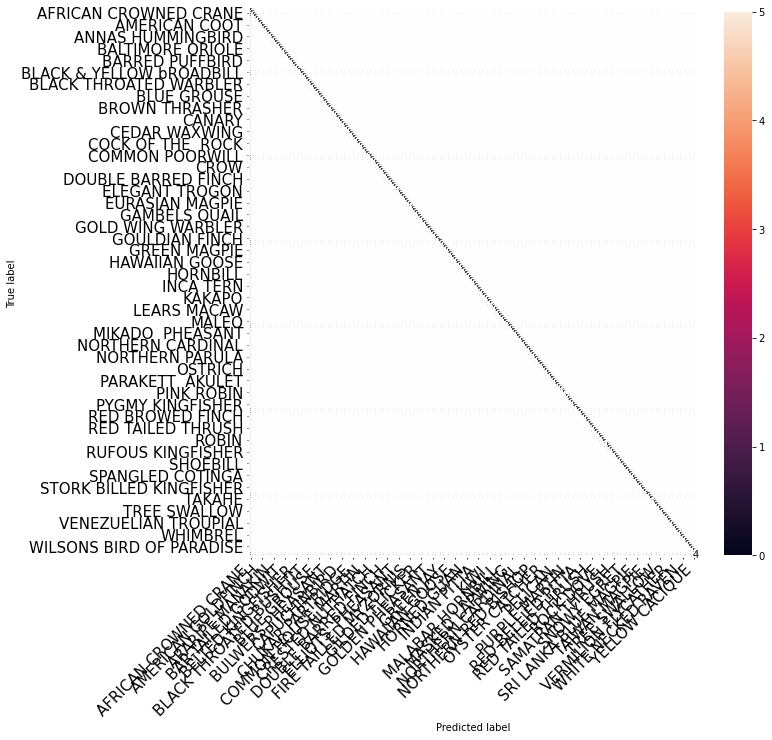

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns

plt.figure(figsize=(10,10))
valid_class_names = list(image_datasets['valid'].classes)
valid_df_cm = pd.DataFrame(valid_confusion_matrix, index=class_names, columns=class_names).astype(int)
valid_heatmap = sns.heatmap(valid_df_cm, annot=True, fmt="d")

valid_heatmap.yaxis.set_ticklabels(valid_heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
valid_heatmap.xaxis.set_ticklabels(valid_heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [10]:
valid_recall = np.diag(valid_df_cm) / np.sum(valid_df_cm, axis = 1)
valid_precision = np.diag(valid_df_cm) / np.sum(valid_df_cm, axis = 0)
print("Recall")
print(valid_recall.mean())

print("\nPresisi")
print(valid_precision.mean())

Recall
0.9927272727272729

Presisi
0.9943939393939395


In [11]:
!pip install disarray

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [12]:
import disarray

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

print('accuracy: {:3f}'.format(accuracy(valid_confusion_matrix)))
print('precision: {:3f}'.format(valid_df_cm.da.precision.mean()))
print('recall: {:3f}'.format(valid_df_cm.da.recall.mean()))
print('f1: {:3f}'.format(valid_df_cm.da.f1.mean()))

accuracy: 0.992727
precision: 0.994394
recall: 0.992727
f1: 0.992460


In [13]:
#TEST
nb_classes = 275

test_confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (test_inputs, test_classes) in enumerate(dataloaders['test']):
        test_inputs = test_inputs.to(device)
        test_classes = test_classes.to(device)
        test_outputs = model_ft(test_inputs)
        _, test_preds = torch.max(test_outputs, 1)
        for t, p in zip(test_classes.view(-1), test_preds.view(-1)):
            test_confusion_matrix[t.long(), p.long()] += 1

print(test_confusion_matrix)

tensor([[5., 0., 0.,  ..., 0., 0., 0.],
        [0., 5., 0.,  ..., 0., 0., 0.],
        [0., 0., 5.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 0., 5., 0.],
        [0., 0., 0.,  ..., 0., 0., 5.]])


Text(0.5, 69.0, 'Predicted label')

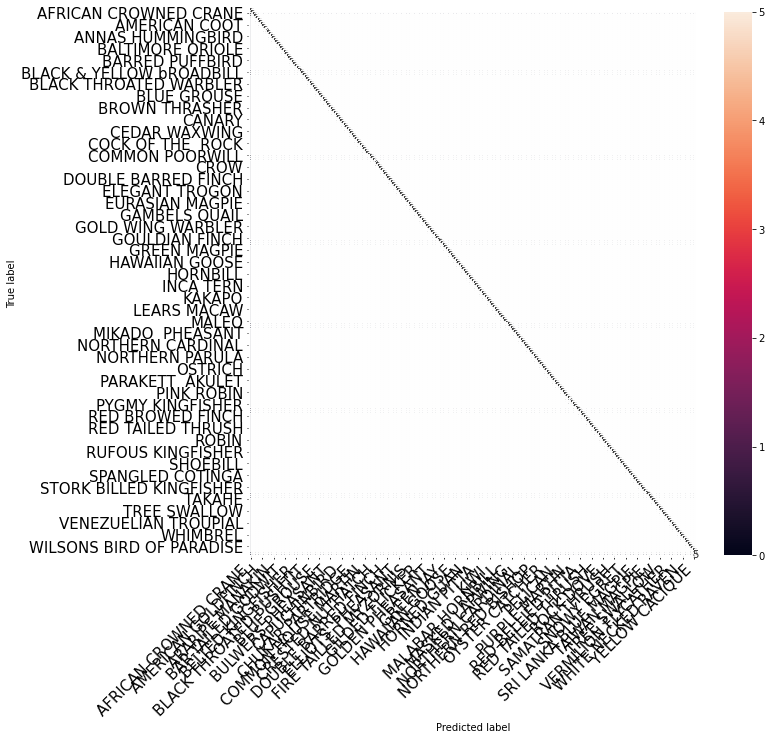

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
plt.figure(figsize=(10,10))
class_names = list(image_datasets['test'].classes)
test_df_cm = pd.DataFrame(test_confusion_matrix, index=class_names, columns=class_names).astype(int)
test_heatmap = sns.heatmap(test_df_cm, annot=True, fmt="d")
test_df_cm.to_csv('BVS1_2_Vision Transformer_SpinalNet_test_confusion_matrix.csv')

test_heatmap.yaxis.set_ticklabels(test_heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
test_heatmap.xaxis.set_ticklabels(test_heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [15]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

test_recall = np.diag(test_df_cm) / np.sum(test_df_cm, axis = 1)
test_precision = np.diag(test_df_cm) / np.sum(test_df_cm, axis = 0)
print("Recall")
print(test_recall.mean())

print("\nPresisi")
print(test_precision.mean())

Recall
0.9978181818181817

Presisi
0.9981818181818182


In [16]:
print('accuracy: {:3f}'.format(accuracy(test_confusion_matrix)))
print('precision: {:3f}'.format(test_df_cm.da.precision.mean()))
print('recall: {:3f}'.format(test_df_cm.da.recall.mean()))
print('f1: {:3f}'.format(test_df_cm.da.f1.mean()))

accuracy: 0.997818
precision: 0.998182
recall: 0.997818
f1: 0.997796


In [ ]:
# test_df_cm.to_excel('BVS1_Vision Transformer_SpinalNet_test_confusion_matrix.xlsx')